In [162]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import csv
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram

In [2]:
def load_data(filepath):
    data = []
    with open(filepath) as f:
        reader = csv.DictReader(f)
        for row in reader:
            data.append(dict(row))
    return data

In [3]:
data = load_data("countries.csv")
data[0]

{'': '0',
 'Country': 'Afghanistan ',
 'Population': '31056997',
 'Net migration': '23.06',
 'GDP ($ per capita)': '700.0',
 'Literacy (%)': '36.0',
 'Phones (per 1000)': '3.2',
 'Infant mortality (per 1000 births)': '163.07'}

In [4]:
def calc_features(row):
    x1 = float(row["Population"])
    x2 = float(row["Net migration"])
    x3 = float(row["GDP ($ per capita)"])
    x4 = float(row["Literacy (%)"])
    x5 = float(row["Phones (per 1000)"])
    x6 = float(row["Infant mortality (per 1000 births)"])
    features = np.array([x1, x2, x3, x4, x5, x6])
    return features

In [280]:
# my version
country_names = [row["Country"] for row in data]
features = [calc_features(row) for row in data]
def hac(features):
    n = len(features)

    # the distance matrix to be maintained.
    d_matrix = distance_matrix(features, features)

    # since we're doing single linkage, we need to replace the zeros with np.inf to help find the min value
    d_matrix = np.where(d_matrix == 0, np.inf, d_matrix)
    
    # create a (n-1) by 4 array
    Z = [[0 for x in range(4)] for y in range(n-1)]

    # iterate through, row by row.
    sizes = {}
    for m in range(n):
        sizes[m] = 1
    
    current_clusters = []
    for i in range(n):
        current_clusters.append(i)
    i = 0
    for row in Z:
        if (len(current_clusters) != 1):
            # for each row, determine which two clusters are closest and put their numbers in the first and second
            # elements of the row, Z[i, 0] and Z[i, 1]. The first element listed, Z[i, 0] should be the smaller 
            # of the 2 cluster indices.
            minimum_distance = np.inf
            lowest_index = -1
            highest_index = -1
            
            for iindex in current_clusters:
                for jindex in current_clusters:
                    if iindex < jindex:
                        d = d_matrix[iindex, jindex]
                        if (d < minimum_distance or (d == minimum_distance and iindex < lowest_index) or (d == minimum_distance and iindex == lowest_index and jindex < highest_index)):
                            minimum_distance = d
                            lowest_index = iindex
                            highest_index = jindex
            
            Z[i][0] = lowest_index
            Z[i][1] = highest_index
    
            # now, the single-linkage distance between the two clusters goes into the 3rd element of the row, Z[i, 2]
            Z[i][2] = minimum_distance
            # the total number of countries in the cluster goes into the fourth element, Z[i, 3]
            Z[i][3] = sizes[lowest_index] + sizes[highest_index]
            
            # now, update the data_with_indices to have the merged clusters
            # The index of the new cluster is n + current number of merges (i)
            
            # now we need to update the distance matrix
            new_row = {}
            for index in current_clusters:
                new_row[index] = min(d_matrix[index, lowest_index], d_matrix[index, highest_index])
            
            # remove the two clusters that were merged
            current_clusters.remove(lowest_index)
            current_clusters.remove(highest_index)
            
            # add the new cluster that is merged
            current_clusters.append(n + i)
            
            # temporarily change the infinities back to zero so that we can make a row/col of zeros to add
            d_matrix = np.where(d_matrix == np.inf, 0, d_matrix)
            
            # make a row/col of zeros so that we can add them
            row1 = [0 for x in range(n + i)]
            
            # now, go through the new row and update those values that we just added
            for item in new_row:
                row1[item] = new_row[item]
            
            # add on the row to the bottom
            d_matrix = np.vstack([d_matrix, row1])
            
            # add a zero so we can have a new column
            row1.append(0)
            
            # add on the column to the right
            d_matrix = np.column_stack([d_matrix, row1])
            
            sizes[n + i] = sizes[lowest_index] + sizes[highest_index]
            
            # change the zeros back to infinities.
            d_matrix = np.where(d_matrix == 0, np.inf, d_matrix)
            
            i = i + 1
    return np.array(Z)


In [281]:
Z = hac(features[:10])
Z

array([[4.00000000e+00, 7.00000000e+00, 8.26945871e+03, 2.00000000e+00],
       [3.00000000e+00, 1.00000000e+01, 1.17085997e+04, 3.00000000e+00],
       [6.00000000e+00, 1.10000000e+01, 4.43215277e+04, 4.00000000e+00],
       [1.00000000e+00, 9.00000000e+00, 6.05283839e+05, 2.00000000e+00],
       [0.00000000e+00, 2.00000000e+00, 1.87310150e+06, 2.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 2.90521236e+06, 6.00000000e+00],
       [8.00000000e+00, 1.40000000e+01, 6.99174394e+06, 3.00000000e+00],
       [5.00000000e+00, 1.50000000e+01, 8.54541640e+06, 7.00000000e+00],
       [1.60000000e+01, 1.70000000e+01, 1.89299260e+07, 1.00000000e+01]])

In [249]:
def fig_hac(Z, names):
    # to return one plot, you need to have dendrogram before fig, for some reason
    dendrogram(Z, labels = names, leaf_rotation = 90)
    fig = plt.figure()
    fig.tight_layout()
    return fig

<Figure size 640x480 with 0 Axes>

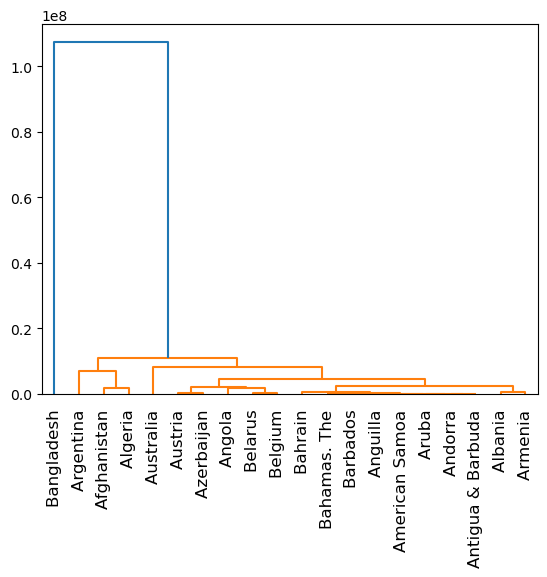

<Figure size 640x480 with 0 Axes>

In [250]:
fig_hac(Z, country_names[:20])

In [251]:
features

[array([3.1056997e+07, 2.3060000e+01, 7.0000000e+02, 3.6000000e+01,
        3.2000000e+00, 1.6307000e+02]),
 array([ 3.581655e+06, -4.930000e+00,  4.500000e+03,  8.650000e+01,
         7.120000e+01,  2.152000e+01]),
 array([ 3.2930091e+07, -3.9000000e-01,  6.0000000e+03,  7.0000000e+01,
         7.8100000e+01,  3.1000000e+01]),
 array([ 5.7794e+04, -2.0710e+01,  8.0000e+03,  9.7000e+01,  2.5950e+02,
         9.2700e+00]),
 array([7.1201e+04, 6.6000e+00, 1.9000e+04, 1.0000e+02, 4.9720e+02,
        4.0500e+00]),
 array([1.2127071e+07, 0.0000000e+00, 1.9000000e+03, 4.2000000e+01,
        7.8000000e+00, 1.9119000e+02]),
 array([1.3477e+04, 1.0760e+01, 8.6000e+03, 9.5000e+01, 4.6000e+02,
        2.1030e+01]),
 array([ 6.9108e+04, -6.1500e+00,  1.1000e+04,  8.9000e+01,  5.4990e+02,
         1.9460e+01]),
 array([3.9921833e+07, 6.1000000e-01, 1.1200000e+04, 9.7100000e+01,
        2.2040000e+02, 1.5180000e+01]),
 array([ 2.976372e+06, -6.470000e+00,  3.500000e+03,  9.860000e+01,
         1.957

In [262]:
def normalize_features(features):
    # mean and standard deviation, altough never used
    means = np.mean(features, axis = 0)
    standard_deviations = np.std(features, axis = 0)
    
    
    # min and max value of the columns
    col_mins = np.min(features, axis = 0)
    col_maxes = np.max(features, axis = 0)
    
    # normalize
    numerator = features - col_mins
    denominator = col_maxes - col_mins
    normalize = numerator / denominator
    return normalize

In [269]:
normalized = normalize_features(features[-10:])

<Figure size 640x480 with 0 Axes>

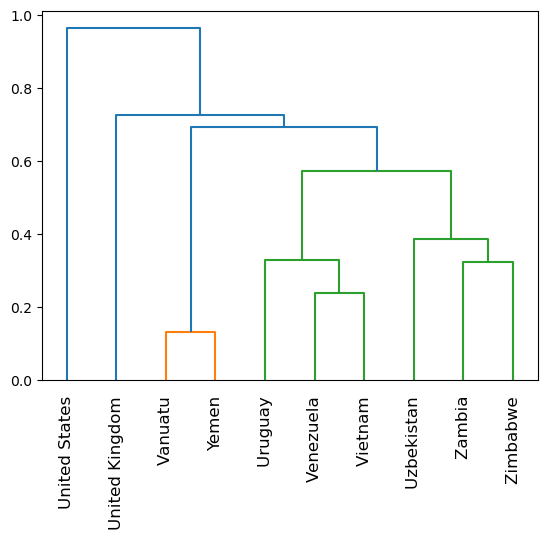

<Figure size 640x480 with 0 Axes>

In [270]:
fig_hac(hac(normalized), country_names[-10:])

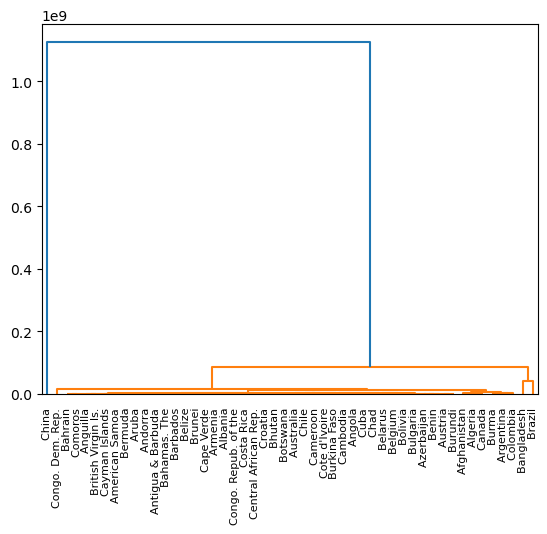

<Figure size 640x480 with 0 Axes>

In [272]:
data = load_data("countries.csv")
country_names = [row["Country"] for row in data]
features = [calc_features(row) for row in data]
features_normalized = normalize_features(features)
n = 50
Z_raw = hac(features[:n])
Z_normalized = hac(features_normalized[:n])
fig = fig_hac(Z_raw, country_names[:n])
plt.show()

In [275]:
Z_normalized

array([[3.80000000e+01, 4.70000000e+01, 1.67143472e-02, 2.00000000e+00],
       [1.20000000e+01, 1.90000000e+01, 2.60946634e-02, 2.00000000e+00],
       [3.90000000e+01, 5.00000000e+01, 4.53431512e-02, 3.00000000e+00],
       [8.00000000e+00, 4.00000000e+01, 4.89642022e-02, 2.00000000e+00],
       [1.10000000e+01, 3.50000000e+01, 6.18152796e-02, 2.00000000e+00],
       [1.00000000e+01, 5.10000000e+01, 6.40725158e-02, 3.00000000e+00],
       [3.20000000e+01, 4.30000000e+01, 6.98559840e-02, 2.00000000e+00],
       [2.30000000e+01, 5.20000000e+01, 7.46091196e-02, 4.00000000e+00],
       [2.00000000e+01, 4.20000000e+01, 7.87960472e-02, 2.00000000e+00],
       [2.10000000e+01, 5.70000000e+01, 8.35520719e-02, 5.00000000e+00],
       [1.40000000e+01, 1.70000000e+01, 8.72003865e-02, 2.00000000e+00],
       [1.80000000e+01, 4.60000000e+01, 8.85258684e-02, 2.00000000e+00],
       [3.10000000e+01, 3.40000000e+01, 8.99181905e-02, 2.00000000e+00],
       [4.80000000e+01, 6.10000000e+01, 9.19869319e